In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# ========== 1. read data ==========
df = pd.read_csv("spiking_time_dataset.csv")

# Extract features and labels
X = df.iloc[:, 1:].values  # Exclude the first column (labels)
y = df.iloc[:, 0].values   # Labels

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Long for classification

In [10]:
# ========== 2. split dataset (train 1600, val 200, test 200) ==========
train_size = 1600
val_size = 200
test_size = 200

train_data, val_data, test_data = random_split(
    TensorDataset(X_tensor, y_tensor), [train_size, val_size, test_size]
)

In [11]:
# ========== 3. DataLoader ==========
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
# ========== 4. MLP model ==========
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=2):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # input shall be (batch_size, 30)
        x = self.fc1(x)
        x = self.relu1(x)
        # x = self.fc2(x)
        # x = self.relu2(x)
        x = self.fc3(x)
        return x

# input size = 30
input_dim = X_tensor.shape[1]

# initialize model
model = MLPClassifier(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# ========== 5. train MLP ==========
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct / total)

    # validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f},\
           Train Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f},\
            Val Acc: {val_accs[-1]:.4f}")

Epoch 1/50 - Train Loss: 1.5367,           Train Acc: 0.7450 | Val Loss: 0.0927,            Val Acc: 0.9750
Epoch 2/50 - Train Loss: 0.0267,           Train Acc: 0.9975 | Val Loss: 0.0127,            Val Acc: 1.0000
Epoch 3/50 - Train Loss: 0.0091,           Train Acc: 1.0000 | Val Loss: 0.0082,            Val Acc: 1.0000
Epoch 4/50 - Train Loss: 0.0062,           Train Acc: 1.0000 | Val Loss: 0.0059,            Val Acc: 1.0000
Epoch 5/50 - Train Loss: 0.0046,           Train Acc: 1.0000 | Val Loss: 0.0044,            Val Acc: 1.0000
Epoch 6/50 - Train Loss: 0.0036,           Train Acc: 1.0000 | Val Loss: 0.0034,            Val Acc: 1.0000
Epoch 7/50 - Train Loss: 0.0029,           Train Acc: 1.0000 | Val Loss: 0.0028,            Val Acc: 1.0000
Epoch 8/50 - Train Loss: 0.0024,           Train Acc: 1.0000 | Val Loss: 0.0024,            Val Acc: 1.0000
Epoch 9/50 - Train Loss: 0.0020,           Train Acc: 1.0000 | Val Loss: 0.0021,            Val Acc: 1.0000
Epoch 10/50 - Train Loss: 0.

In [15]:
# ========== 6. test ==========
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, predicted = outputs.max(1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(predicted.tolist())

# R², MSE, Accuracy
accuracy = accuracy_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R² Score: {r2:.4f}")

Test Accuracy: 1.0000
Test MSE: 0.0000
Test R² Score: 1.0000


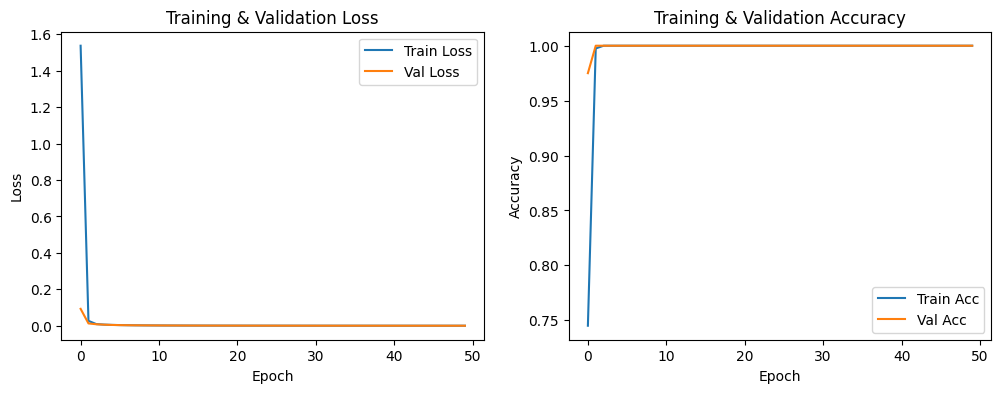

In [16]:
# ========== 7. train visualization ==========
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()